In [22]:
from time import time
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from datetime import datetime, timedelta
import ensemble_kalman_filter as enkf
from tqdm import tqdm
from bayes_opt import BayesianOptimization
from rebayes_mini.methods import robust_filter as rkf
from rebayes_mini import callbacks
import os

In [23]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
plt.style.use("default")
plt.rcParams["font.size"] = 18

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
model_name = 'lorenz96mc10'
save_flag = False
save_dir ='../dataset/'+ model_name +'/'
corrupted = False
f_inacc = False
ALPHA=2.0 
BETA=2.0
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
M = 100
N = 200    
D = 72
kain_var = np.sqrt(100)  # Standard deviation of measurement noise
dim_state = D
dim_obs = D
F = 8.0
dt = 0.01  # Time step size
# ixs = jnp.arange(D)
key = jax.random.PRNGKey(31415)
key_init, key_sim, key_eval, key_obs = jax.random.split(key, 4)
key_state, key_measurement = jax.random.split(key_sim)
key_obs, key_mc = jax.random.split(key_obs)
X0 = jax.random.normal(key_mc, (D,)) + F
mu0, cov0 = X0, jnp.eye(dim_state) * 0.01**2  # Mean and covariance of initial state
key = jax.random.PRNGKey(31415)
key_init, key_sim, key_eval, key_obs = jax.random.split(key, 4)
key_state, key_measurement = jax.random.split(key_sim)

@partial(jax.vmap, in_axes=(None, 0, None))
def fcoord(x, k, D):
    xdot = (x[(k + 1) % D] - x[k - 2]) * x[k - 1] - x[k] + F
    return xdot

def f(x, t, D, *args):
    keyt = jax.random.fold_in(key_state, t)
    err = jax.random.normal(keyt, shape=(D,))
    ixs = jnp.arange(D)
    xdot = fcoord(x, ixs, D) + err
    return xdot

def fC(x, t, D, *args):
    keyt = jax.random.fold_in(key_state, t)
    err = jax.random.normal(keyt, shape=(D,))
    key_a, key_b = jax.random.split(keyt)
    ixs = jnp.arange(D)
    dx_mod = fcoord(x, ixs, D) + err
    a = jax.random.uniform(key_a, x.shape, minval=-ALPHA, maxval=ALPHA)
    b = jax.random.uniform(key_b, x.shape, minval=-BETA, maxval=BETA)
    # 应用调整，注意这里的 dx_mod 是不可变的操作
    dx_mod = dx_mod.at[0].set(dx_mod[0] - a[0] * x[1] + b[0])
    return dx_mod


def hcoord(x, t):
    """Linear observation function."""
    return x

def h(x, t, D, *args):
    """Observation function with added measurement noise."""
    keyt = jax.random.fold_in(key_measurement, t)
    err = jax.random.normal(keyt, shape=(D,))
    ydot = hcoord(x, t) + kain_var * err
    return ydot

# Time-stepping function for observations
def h_step(ys, dt, N, h):
    """Iteratively compute observations over time."""
    yss = jnp.zeros((N, dim_obs))

    def step(i, carry):
        """Single step update for observation computation."""
        yss, ys = carry
        ysi = h(ys[i - 1], dt * i)
        yss = yss.at[i].set(ysi)
        return (yss, ys)

    yss, ys = jax.lax.fori_loop(1, N, step, (yss, ys))
    return yss

# Helper functions for dynamics and observations
def ff(x):
    """Wrapper for state dynamics."""
    return fcoord(x, dt)

def hh(x, t):
    """Wrapper for linear observation function."""
    return hcoord(x, t)

In [25]:
from data_generation import generate_and_save_data, load_data
from filtering_methods import run_filtering
if save_flag:
    statev, yv, yv_corrupted = generate_and_save_data(
        M, N, dt, dim_state, dim_obs, mu0, cov0, key_init, key_obs,
        f, fC, h, h_step, save_dir, model_name, save_flag, corrupted, f_inacc
    )
else:
    statev, yv, yv_corrupted = load_data(save_dir, model_name, M, N, dim_state, dim_obs, corrupted)

In [26]:
print(statev.shape, yv.shape)

(100, 200, 72) (100, 200, 72)


In [28]:
print('System', model_name)
print('corrupted', corrupted)
print('f_inacc', f_inacc)
methods = ['EKF', 'EnKF', 'EnKFI', 'HubEnKF', 'EnKFS', 'PF']
# methods = ['EnKFS']
if corrupted:
    yv_test = yv_corrupted[int(M * 0.8):]
else:
    yv_test = yv[int(M * 0.8):]
statev_test = statev[int(M * 0.8):]
_, _, _ = run_filtering(methods, yv_test, statev_test, key_eval, ff, hh, num_particle=1000)

System lorenz96mc10
corrupted False
f_inacc False
EKF


  0%|          | 0/20 [00:00<?, ?it/s]

ValueError: vmap in_axes must be an int, None, or a tuple of entries corresponding to the positional arguments passed to the function, but got len(in_axes)=3, len(args)=2

In [5]:
sigma = 10.
beta = 8./3
rho = 28.


def f(state, t):
    x, y, z = state
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return jnp.array([xdot, ydot, zdot])

y0 = jnp.ones(3)
N = 5000
ys = jnp.zeros((N,) + y0.shape)
ys = ys.at[0].set(y0)
res = rk4(ys, 0.004, N, f)
# ax = plt.figure().add_subplot(projection='3d')
# ax.plot(*res.T, lw=1.0, c="teal")
# print(res.shape)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


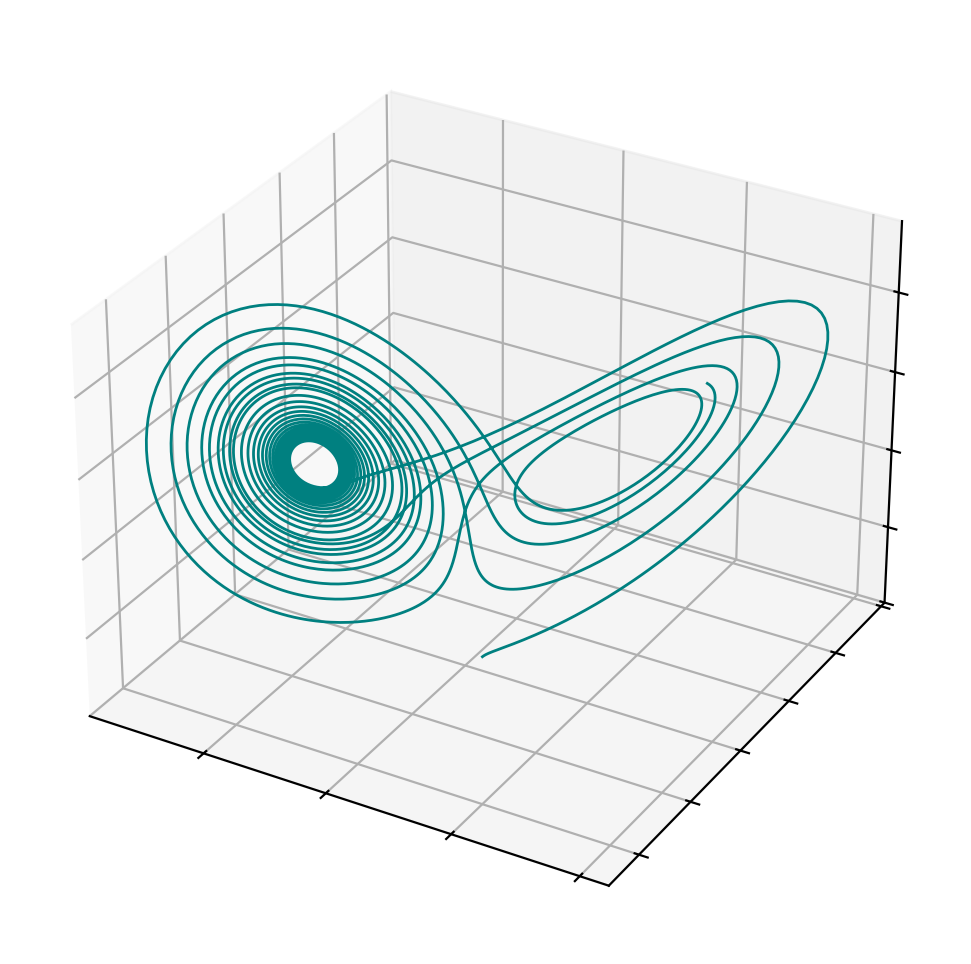

In [6]:
# 创建尺寸为 10:6 的 figure
fig = plt.figure(figsize=(10, 6))

# 添加一个 3D 子图
ax = fig.add_subplot(projection='3d')

# 绘制 3D 曲线
ax.plot(*res.T, lw=1.0, c="teal")
ax.grid(True)
# 移除坐标轴数值标签
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# 显示图形
plt.show()

$$
    \dot{\bf x}_k = \Big({\bf x}_{k+1} - {\bf x}_{k-2}\Big) {\bf x}_{j-1} - {\bf x}(j) + {F}_k
$$


In [8]:
n_mc = 100
N = 200
dt = 0.01
p_err = 0.01
kain_var = 10.0
xs_mc = []
ys_mc = []
ys_corrupted_mc = []
key_obs, key_mc = jax.random.split(key_obs)
for i in range(n_mc):
    key_mc, subkey = jax.random.split(key_mc)  # 生成新的子随机数生成器
    x0 = jax.random.normal(key_mc, (D,)) + F
    xs1 = jnp.zeros((N,) + x0.shape)
    xs1 = xs1.at[0].set(x0)
    if f_inacc:
        fpart = partial(fC, D=dim_state)
    else:
        fpart = partial(f, D=dim_state)
    xs1 = rk4(xs1, dt, N, fpart)
    ys1 = xs1 + kain_var * jax.random.normal(key_measurement, xs1.shape)
    ys1_corrupted = ys1.copy()
    if corrupted:
        errs_map = jax.random.bernoulli(key_init, p=p_err, shape=ys1_corrupted.shape)
        ys1_corrupted = ys1_corrupted * (~errs_map) + 100.0 * errs_map
        err_where = np.where(errs_map)
    xs_mc.append(xs1)
    ys_mc.append(ys1)
    ys_corrupted_mc.append(ys1_corrupted)
statev = jnp.array(xs_mc)
yv = jnp.array(ys_mc)
yv_corrupted = jnp.array(ys_corrupted_mc)
print(statev.shape)
print(yv.shape)
print(yv_corrupted.shape)

(100, 200, 72)
(100, 200, 72)
(100, 200, 72)


In [9]:
ys = yv.reshape(-1, D)
ys_corrupted = yv_corrupted.reshape(-1, D)
xs = statev.reshape(-1, D)
print(xs.shape,ys.shape)

(20000, 72) (20000, 72)


In [10]:
# 生成时间序列
start_time = datetime(2024, 6, 22, 13, 0, 0)
time_interval = timedelta(seconds=1)
time_series = [start_time + i * time_interval for i in range(xs.shape[0])]

# 创建 DataFrame
column_names = [f'x_{i}' for i in range(1, xs.shape[1] + 1)]
df = pd.DataFrame(xs, columns=column_names)
df.insert(0, 'date', time_series)

print(df.head())

                 date       x_1       x_2       x_3       x_4       x_5  \
0 2024-06-22 13:00:00  7.930324  8.413463  7.601623  9.190229  8.475810   
1 2024-06-22 13:00:01  7.930321  8.499139  7.700241  9.180872  8.417858   
2 2024-06-22 13:00:02  7.939756  8.589506  7.797289  9.159656  8.342128   
3 2024-06-22 13:00:03  7.958960  8.685142  7.890883  9.124665  8.249687   
4 2024-06-22 13:00:04  7.988383  8.786439  7.978894  9.074028  8.141981   

        x_6       x_7       x_8       x_9  ...      x_63      x_64      x_65  \
0  7.100482  7.611787  8.599230  5.906620  ...  8.527282  8.186784  8.320616   
1  6.994057  7.628078  8.514590  5.835321  ...  8.471459  8.095998  8.379319   
2  6.892287  7.642980  8.433003  5.761547  ...  8.405712  8.009196  8.436461   
3  6.796344  7.657907  8.353943  5.687179  ...  8.330429  7.927396  8.492678   
4  6.707585  7.674090  8.276908  5.613890  ...  8.246227  7.851594  8.548414   

       x_66      x_67      x_68      x_69      x_70      x_71      x

In [11]:
if save_flag:
    # # 保存为 CSV 文件
    csv_path = save_dir + model_name + '.csv'
    df.to_csv(csv_path, index=False)
    # 创建 DataFrame
    column_names = [f'y_{i}' for i in range(1, ys.shape[1] + 1)]
    dfy = pd.DataFrame(ys, columns=column_names)
    dfy.insert(0, 'date', time_series)

    print(dfy.head())
    csv_path = save_dir + model_name + '_obs.csv'
    dfy.to_csv(csv_path, index=False)

    if corrupted:
        column_names = [f'y_{i}' for i in range(1, ys_corrupted.shape[1] + 1)]
        dfy = pd.DataFrame(ys_corrupted, columns=column_names)
        dfy.insert(0, 'date', time_series)

        print(dfy.head())
        csv_path = save_dir + model_name + '_obs_corrupted.csv'
        dfy.to_csv(csv_path, index=False)

In [12]:
range_time = np.arange(N) * dt
np.set_printoptions(precision=4)

def callback_fn(particles, particles_pred, y, i):
    return jnp.sqrt(jnp.power(particles.mean(axis=0) - xs[i], 2).mean()), particles.mean(axis=0)
def latent_fn(x, key, i):
    """
    State function
    """
    err = jax.random.normal(key, (D,))
    @jax.jit
    def f(x, t):
        ixs = jnp.arange(D)
        return fcoord(x, ixs, D) + F + err
    
    return rk4_step(x, i, dt, f)

def f_step(x):
    ixs = jnp.arange(D)
    return fcoord(x, ixs, D) + F

def h_step(x, _):
    return x

def obs_fn(x, key, i):
    """
    Measurement function
    """
    err = jax.random.normal(key, (D,))
    return x + err

def calculate_mse(errs):
    return jnp.mean(jnp.square(errs))
def calculate_mae(errs):
    return jnp.mean(jnp.abs(errs))

def calculate_rmse(errs):
    return jnp.sqrt(jnp.mean(jnp.square(errs)))

def calculate_test_error(errs):
    mse = calculate_mse(errs)
    mae = calculate_mae(errs)
    rmse = calculate_rmse(errs) 
    print(f'mse:{mse}, mae:{mae}, rmse:{rmse}')
    return mse, mae, rmse
M = n_mc
ff = f_step
hh = h_step

In [13]:
print(statev.shape)
print(yv.shape)
print(yv_corrupted.shape)

(100, 200, 72)
(100, 200, 72)
(100, 200, 72)


In [ ]:
from filtering_methods import run_filtering
print('System', model_name)
print('corrupted', corrupted)
print('f_inacc', f_inacc)
methods = ['EKF', 'EnKF', 'EnKFI', 'HubEnKF', 'EnKFS', 'PF']
# methods = ['PF']
if corrupted:
    yv_test = yv_corrupted[int(M * 0.8):]
else:
    yv_test = yv[int(M * 0.8):]
statev_test = statev[int(M * 0.8):]
parameter_range = (1, 20)
_, _, _ = run_filtering(methods, yv_test, statev_test, key_eval, ff, hh, parameter_range, num_particle=1000)

System lorenz96mc10
corrupted False
f_inacc False
EKF


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


EnKF


100%|██████████| 20/20 [00:41<00:00,  2.07s/it]


EnKFI


100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


HubEnKF


100%|██████████| 20/20 [00:43<00:00,  2.16s/it]


EnKFS


100%|██████████| 20/20 [00:45<00:00,  2.25s/it]


PF


100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Done
RMSE
{'EKF': Array(nan, dtype=float32),
 'EnKF': Array(6.6024, dtype=float32),
 'EnKFI': Array(3.7739, dtype=float32),
 'EnKFS': Array(4.5552, dtype=float32),
 'HubEnKF': Array(3.0602, dtype=float32),
 'PF': Array(nan, dtype=float32)}
Time
{'EKF': np.float64(2.2721546292304993),
 'EnKF': np.float64(10.360103964805603),
 'EnKFI': np.float64(8.420436441898346),
 'EnKFS': np.float64(11.252490043640137),
 'HubEnKF': np.float64(10.796804130077362),
 'PF': np.float64(6.42235952615738)}


: 